In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install grad-cam --quiet

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


In [ ]:
!pip install monai -q
import monai

In [ ]:
NUM_CLASSES = 3

from monai.transforms import (
    Activations, #End of neural network activaitons, that turns values from the CNN into probabilities
    AsDiscrete, #Turns probabilites into discrete values
    Compose, #Sums together image transformations
    LoadImage, #Loads image from file directory, converts to tensor format
    LoadImaged,
    RandRotate90,
    RandWeightedCropd,
    RandSpatialCrop,
    RandCropByLabelClasses,
    RandSpatialCropSamples,
    RandRotated,
    # AddChanneld,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    RandRotate90d,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    ToTensord,
    RandCropByPosNegLabel,
    ScaleIntensity,
    AsDiscreted,
    RandRotated,
    RandSpatialCropSamplesd,
    RandSpatialCropd,
    Resized
)
from monai.visualize import plot_2d_or_3d_image
from torch.nn.functional import softmax

post_trans = Compose(
    [
        Activations(softmax=True),
        AsDiscrete(argmax=True, to_onehot=3)
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img"]),
        AsDiscreted(keys="seg", to_onehot=NUM_CLASSES),
    ]
)

In [ ]:
!pip install pynrrd -q
import nrrd

In [ ]:
import cv2 as cv

In [ ]:
scan, h = nrrd.read(os.path.join(runtime_dir, 'scan.nrrd'))
mask, h = nrrd.read(os.path.join(runtime_dir, 'mask.nrrd'))

print(scan.shape, mask.shape)
scan = cv.resize(scan, (512, 512))
mask = cv.resize(mask, (512, 512))
print(scan.shape, mask.shape)

max_slice = 0
max_lg_pixels = 0

for i in range(scan.shape[2]):
    lg_pixels = np.count_nonzero(mask[:, :, i])
    if lg_pixels > max_lg_pixels:
        max_lg_pixels = lg_pixels
        max_slice = i

print(max_slice, max_lg_pixels)

scan_selected_slice = scan[:, :, max_slice]
mask_selected_slice = mask[:, :, max_slice]

patch_sz = 128

def decompose_image(scan_selected_slice, mask_selected_slice):
    scan_patches = []
    mask_patches = []

    for i in range(0, scan_selected_slice.shape[0]//patch_sz):
        for j in range(0, scan_selected_slice.shape[1]//patch_sz):
            scan_patch = scan_selected_slice[i*patch_sz:(i+1)*patch_sz, j*patch_sz:(j+1)*patch_sz]
            mask_patch = mask_selected_slice[i*patch_sz:(i+1)*patch_sz, j*patch_sz:(j+1)*patch_sz]
            scan_patches.append(scan_patch)
            mask_patches.append(mask_patch)

    return scan_patches, mask_patches

scan_patches, mask_patches = decompose_image(scan_selected_slice, mask_selected_slice)

input_tensor = torch.tensor(scan_patches[0], dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
input_tensor.shape


(256, 256, 17) (256, 256, 17)
(512, 512, 17) (512, 512, 17)
9 877


torch.Size([1, 1, 128, 128])

In [ ]:
model_path = os.path.join(runtime_dir, 'model.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(model_path))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMElementWise, GradCAMPlusPlus, FullGrad, HiResCAM, XGradCAM, AblationCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


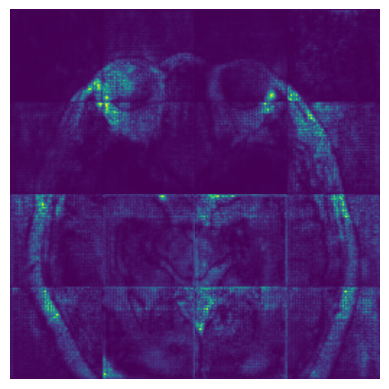

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


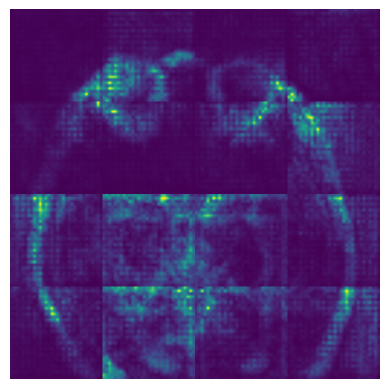

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


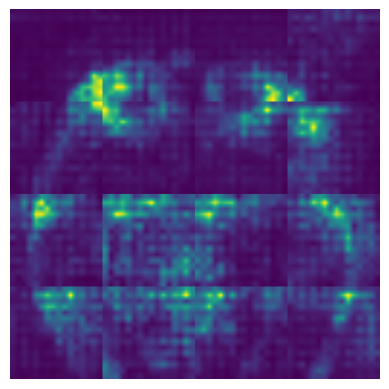

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


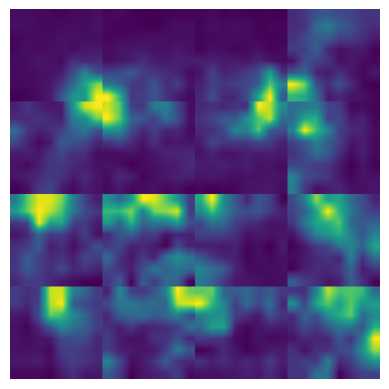

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


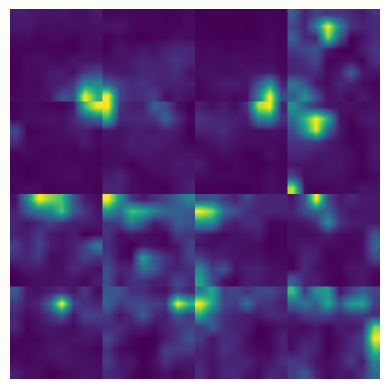

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


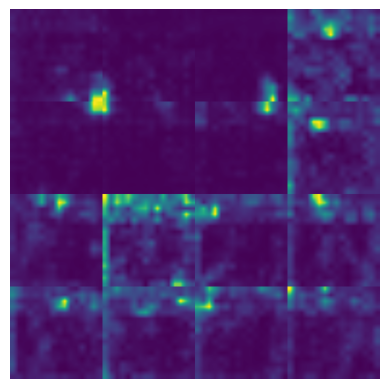

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


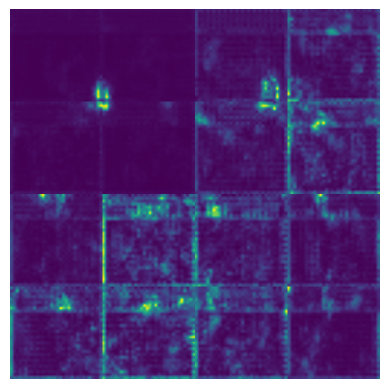

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


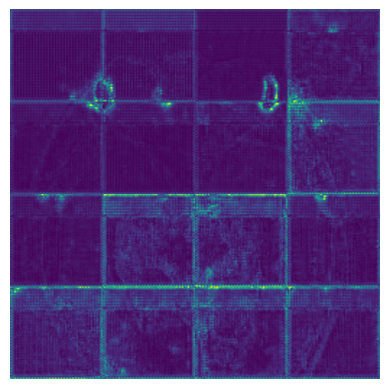

Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


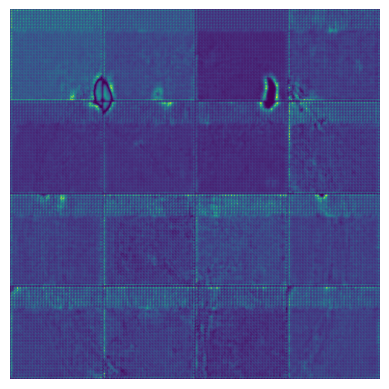

In [ ]:

lg_category = 2 # 1 is left 2 is right

target_layers_list = [model.model[0].conv.unit1.conv,
model.model[1].submodule[0].conv.unit1.conv,
model.model[1].submodule[1].submodule[0].conv.unit1.conv,
model.model[1].submodule[1].submodule[1].submodule[0].conv.unit1.conv,
model.model[1].submodule[1].submodule[1].submodule[1].submodule.conv.unit1.conv,
model.model[1].submodule[1].submodule[1].submodule[2][1].conv.unit0.conv,
model.model[1].submodule[1].submodule[2][1].conv.unit0.conv,
model.model[1].submodule[2][1].conv.unit0.conv,
model.model[2][1].conv.unit0.conv,
                      ]

scan_patches, mask_patches = decompose_image(scan_selected_slice, mask_selected_slice)

for target_layer in target_layers_list:

    cam_images = []

    print(target_layer)

    for i in range(len(scan_patches)):
        img = scan_patches[i]
        seg = mask_patches[i]

        input_tensor = torch.tensor(img, dtype=torch.float32)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
        input_tensor.shape
        input_tensor = ScaleIntensity()(input_tensor)

        if torch.cuda.is_available():
            model = model.cuda()
            input_tensor = input_tensor.cuda()

        output = model(input_tensor)
        # print(output.shape)
        lg_mask_float = output.cpu().detach().numpy()
        # print(lg_mask_float.shape)
        lg_mask_float = lg_mask_float[0,lg_category, :,:]

        target_layers = [target_layer]
        targets = [SemanticSegmentationTarget(lg_category, lg_mask_float)]


        with GradCAMElementWise(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
            #print(grayscale_cam.shape)

        cam_image_npy = np.array(grayscale_cam)
        #cam_image_npy = (cam_image_npy - np.min(cam_image_npy)) / (np.max(cam_image_npy) - np.min(cam_image_npy))
        cam_images.append(cam_image_npy)
        # plt.imshow(cam_image)
        # plt.show()



    reconstructed_image = np.zeros((512, 512))

    for i in range(4):
        for j in range(4):
            reconstructed_image[i*128:(i+1)*128, j*128:(j+1)*128] = cam_images[i*4+j]

    reconstructed_image = np.rot90(reconstructed_image, k=3)
    plt.axis('off')
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.imshow(reconstructed_image)
    plt.show()

